In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from vllm import LLM, SamplingParams


/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 03-12 10:05:29 __init__.py:190] Automatically detected platform cuda.


2025-03-12 10:05:29,419	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom/checkpoint-563")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-773")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-300")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-1268")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-700")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-FT-WS/checkpoint-400")
llm = LLM(model="outputs/Qwen-0.5B-GRPO-HI/checkpoint-500")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-TomC-FT-WS/checkpoint-200")


INFO 03-12 10:05:32 config.py:542] This model supports multiple tasks: {'score', 'generate', 'classify', 'reward', 'embed'}. Defaulting to 'generate'.
INFO 03-12 10:05:32 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='outputs/Qwen-0.5B-GRPO-HI/checkpoint-500', speculative_config=None, tokenizer='outputs/Qwen-0.5B-GRPO-HI/checkpoint-500', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=outputs/Qwen-0

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.06it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.06it/s]


INFO 03-12 10:05:34 model_runner.py:1115] Loading model weights took 0.9277 GB


INFO 03-12 10:05:35 worker.py:267] Memory profiling takes 0.49 seconds
INFO 03-12 10:05:35 worker.py:267] the current vLLM instance can use total_gpu_memory (23.99GiB) x gpu_memory_utilization (0.90) = 21.59GiB
INFO 03-12 10:05:35 worker.py:267] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 19.14GiB.
INFO 03-12 10:05:35 executor_base.py:110] # CUDA blocks: 104553, # CPU blocks: 21845
INFO 03-12 10:05:35 executor_base.py:115] Maximum concurrency for 32768 tokens per request: 51.05x
INFO 03-12 10:05:35 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]

INFO 03-12 10:05:44 model_runner.py:1562] Graph capturing finished in 9 secs, took 0.05 GiB
INFO 03-12 10:05:44 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 10.00 seconds


In [4]:
sampling_params = SamplingParams(temperature=0.6, max_tokens=512, top_p = 0.95)

# read data

In [5]:
from datasets import load_dataset, Dataset
import re
from tqdm import tqdm
import json

In [6]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    if answer is None:
        return None
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized


In [7]:
def reward_func_(response, answer):
    response_ = extract_xml_answer(response)
    norm_response = normalize_answer(response_)
    norm_answer = normalize_answer(answer)
    if norm_response:
        if norm_response == norm_answer:
            return 1
        elif "in the " in norm_response:
            if norm_response.split('in the ')[-1] == norm_answer:
                return 1
        elif "\"" in norm_response:
            if norm_response.split("\"")[-1].split("\"")[0]== norm_answer:
                return 1
    
    return 0


def reward_func(response, answer):
    response_ = extract_xml_answer(response)
    if response_:
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(norm_answer) + r"\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 1
        else:
            return 0
    return 0

In [8]:
def main_func(llm, testset, n, n_repeat=5):
    # Initialize result storage
    all_results = []
    if type(testset)==pd.core.frame.DataFrame:
        testset.index = range(len(testset))
    # Iterate through test set in chunks of n
    with tqdm(range(0, len(testset['prompt']), n), desc="Processing batches") as pbar:
        for i in pbar:
    #for i in tqdm(range(0, len(testset['prompt']), n), desc="Processing batches"):
            # Extract current batch of prompts and answers
            batch_prompts = [p for p in testset['prompt'][i:i+n]]
            batch_answers = [a for a in testset['answer'][i:i+n]]

            # Get outputs from the LLM for the current batch
            for k in range(n_repeat):
                try:
                    outputs = llm.chat(batch_prompts, 
                                    sampling_params=sampling_params, 
                                    use_tqdm=False)

                    # Check correctness for the batch
                    is_correct = [reward_func(each.outputs[0].text, answer) for each, answer in zip(outputs, batch_answers)]
                    # Add detailed results for each item in the batch
                    for j in range(len(batch_prompts)):
                        result_entry = {
                            "prompt": batch_prompts[j],
                            "answer": batch_answers[j],
                            "output": outputs[j].outputs[0].text,  # Assuming this is how to get the output
                            "correctness": is_correct[j],
                            'extract_answer':normalize_answer(extract_xml_answer(outputs[j].outputs[0].text))
                        }
                        all_results.append(result_entry)
                except:
                    print(k, i, i+n)
                    # for each in batch_prompts:
                    #     print(each)
                    #correct=[each['correctness'] for each in all_results]
                    #print(f"Correct: {np.mean(np.array(correct).flatten())}")
                    if k == n_repeat-1:
                        return all_results
                break
            
            if i%5 == 0:
                correct=[each['correctness'] for each in all_results]
                pbar.set_postfix(accuracy=np.mean(np.array(correct).flatten()))

    # Save results to JSON file
    #save_results(all_results)
    correct=[each['correctness'] for each in all_results]
    print(f"Correct: {np.mean(np.array(correct).flatten())}")
    return pd.DataFrame(all_results)

def save_results(results, filename="data/results/evaluation_tom.json"):
    """Saves the evaluation results to a JSON file."""
    with open(filename, mode='w') as file:
        json.dump(results, file, indent=4)
    print(f"Results saved to {filename}")

In [39]:
testset = load_dataset('parquet', data_files='data/test/ToM_test.parquet')['train']
trainset = load_dataset('parquet', data_files='data/train/ToM_train.parquet')['train']

Generating train split: 2000 examples [00:00, 149167.94 examples/s]


In [10]:
testset

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'data_source', 'prompt', 'ability', 'reward_model', 'extra_info', 'story_structure', 'infilled_story', 'question_type', 'params', 'nth_order', 'is_interesting', 'story_type', 'story_structure_wn'],
    num_rows: 1600
})

In [42]:
df = pd.DataFrame(trainset)
dft = pd.DataFrame(testset)
df = df.fillna(0)

<Axes: xlabel='question_order', ylabel='count'>

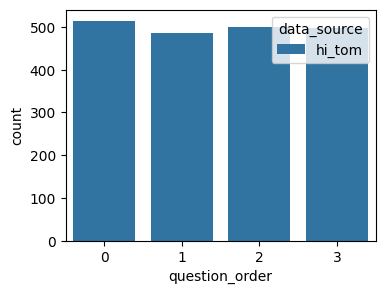

In [44]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.countplot(x='question_order', hue='data_source', data=df)

In [13]:
test_results = main_func(llm, testset, 5, n_repeat=3)

Processing batches:   0%|          | 0/320 [00:00<?, ?it/s]

INFO 03-12 10:06:15 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processing batches: 100%|██████████| 320/320 [01:00<00:00,  5.33it/s, accuracy=0.55] 

Correct: 0.55


In [14]:
dfrt = pd.DataFrame(test_results)
dfrt['question_order']=testset['question_order']
dfrt['nth_order']=testset['nth_order']
dfrt['data_source']=testset['data_source']
dfrt = dfrt.fillna(0)
dfrt['Order']=dfrt.nth_order+dfrt.question_order
dfrt.head()

,prompt,answer,output,correctness,extract_answer,question_order,nth_order,data_source,Order
0,[{'content': 'You are a helpful assistant. The...,green_suitcase,<think> Benjamin thinks Emily thinks Evelyn th...,0,the green_basket,4.0,0.0,hi_tom,4.0
1,[{'content': 'You are a helpful assistant. The...,red_drawer,<think> Hannah thinks Noah thinks Mason thinks...,1,the red_drawer,4.0,0.0,hi_tom,4.0
2,[{'content': 'You are a helpful assistant. The...,red_drawer,<think> Benjamin thinks Hannah thinks Noah thi...,1,the red_drawer,4.0,0.0,hi_tom,4.0
3,[{'content': 'You are a helpful assistant. The...,green_pantry,<think> Nathan thinks Chloe thinks Noah thinks...,1,the green_pantry,4.0,0.0,hi_tom,4.0
4,[{'content': 'You are a helpful assistant. The...,red_crate,<think> Olivia thinks Lily thinks Amelia think...,1,the red_crate,4.0,0.0,hi_tom,4.0


In [16]:
len(testset['data_source'])

1600

In [17]:
len(dfrt)

1600

<Axes: xlabel='Order', ylabel='count'>

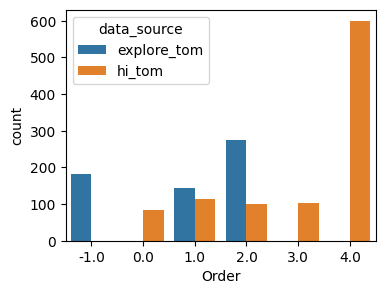

In [38]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.countplot(x='Order', hue='data_source', data=dfrt)

<Axes: xlabel='Order', ylabel='correctness'>

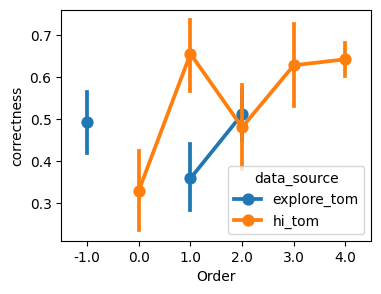

In [37]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='Order', y='correctness', hue='data_source', data=dfrt)

<Axes: xlabel='data_source', ylabel='correctness'>

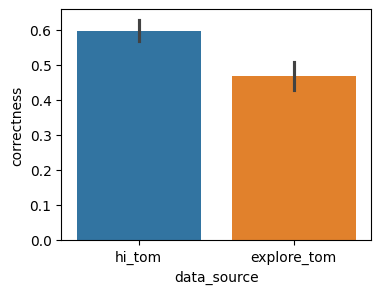

In [58]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.barplot(x='data_source', y='correctness', hue='data_source', data=dfrt)

In [59]:
dfrt.groupby('data_source').correctness.mean()

data_source
explore_tom    0.468333
hi_tom         0.599000
Name: correctness, dtype: float64

In [48]:
dfrt.loc[(dfrt.Order==0)&(dfrt.correctness==0)].iloc[0].output

'<think> Lily made no movements and stayed in the pantry for 1 minute. </think> \n<answer> The red_treasure_chest </answer>'

In [49]:
dfrt.loc[(dfrt.Order==0)&(dfrt.correctness==0)].iloc[0].prompt

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Lily lost his watch. Elizabeth, Lily, Avery, Jayden and Oliver entered the pantry. Lily saw a monkey. The spinach is in the red_treasure_chest. Avery lost his phone. Elizabeth made no movements and stayed in the pantry for 1 minute. Elizabeth exited the pantry. Lily made no movements and stayed in the pantry for 1 minute. Lily exited the pantry. Avery moved the spinach to the green_bottle. Oliver likes the red_crate. Avery exited the pantry. Jayden made no movements and stayed in the pantry for 1 minute. Jayden exited the pantry. Avery saw a dog. Oliver made no movements and stayed in the pantry for 1 min

# Other Set

In [26]:
test_faux = load_dataset('parquet', data_files='data/test/test_faux.parquet')['train']
test_hitom = load_dataset('parquet', data_files='data/test/test_hitom.parquet')['train']
test_tomi = load_dataset('parquet', data_files='data/test/test_tomi.parquet')['train']

test_hitom_num = load_dataset('parquet', data_files='data/test/test_hitom_num.parquet')['train']
test_tomi_num = load_dataset('parquet', data_files='data/test/test_tomi_num.parquet')['train']

Generating train split: 176 examples [00:00, 31129.19 examples/s]
Generating train split: 600 examples [00:00, 116287.71 examples/s]
Generating train split: 5994 examples [00:00, 780547.62 examples/s]
Generating train split: 600 examples [00:00, 149760.91 examples/s]
Generating train split: 5994 examples [00:00, 958104.35 examples/s]


In [27]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

In [28]:
test_hitom['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Charlotte, Isabella, Elizabeth and Owen entered the living_room. lettuce is in the green_drawer. moved the lettuce to the green_bathtub. dislikes the tangerine. exited the living_room. moved the lettuce to the blue_pantry. likes the green_envelope. exited the living_room. made no movements and stayed in the living_room for 1 minute. exited the living_room. dislikes the green_pepper. made no movements and stayed in the living_room for 1 minute. exited the living_room. moved the lettuce to the green_drawer. exited the living_room. Charlotte, Isabella, Elizabeth and Owen entered the waiting_room.\n Question:

In [29]:
results_hitom = main_func(llm, test_hitom, 5, n_repeat=3)

Processing batches: 100%|██████████| 120/120 [00:30<00:00,  4.00it/s, accuracy=0.48] 

Correct: 0.48


In [30]:
results_hitom_num = main_func(llm, test_hitom_num, 5, n_repeat=3)

Processing batches: 100%|██████████| 120/120 [00:20<00:00,  5.87it/s, accuracy=0.43] 

Correct: 0.43


<Axes: ylabel='correctness'>

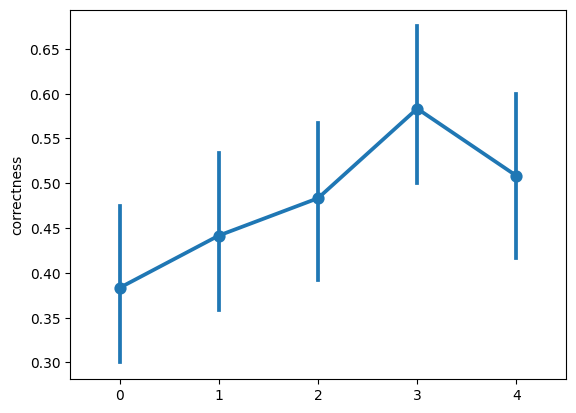

In [31]:
sns.pointplot(x = test_hitom['question_order'], y = results_hitom['correctness'])

In [32]:
results_tomi = main_func(llm, test_tomi, 5, n_repeat=3)

Processing batches: 100%|██████████| 1199/1199 [03:38<00:00,  5.49it/s, accuracy=0.446]

Correct: 0.44644644644644643


In [33]:
test_tomi

Dataset({
    features: ['story', 'question', 'answer', 'question_type', 'prompt'],
    num_rows: 5994
})

<Axes: ylabel='correctness'>

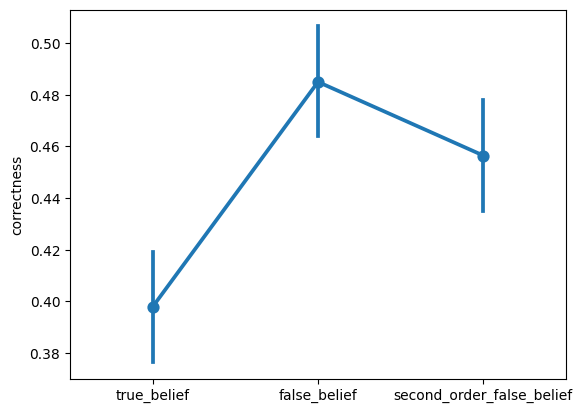

In [34]:
sns.pointplot(x = test_tomi['question_type'], y = results_tomi['correctness'])

In [35]:
results_tomi_num = main_func(llm, test_tomi_num, 5, n_repeat=3)

Processing batches: 100%|██████████| 1199/1199 [03:11<00:00,  6.26it/s, accuracy=0.444]

Correct: 0.4437771104437771


In [60]:
results_faux = main_func(llm, test_faux, 5, n_repeat=3)

Processing batches: 100%|██████████| 36/36 [00:31<00:00,  1.15it/s, accuracy=0.29] 

Correct: 0.2897727272727273


In [61]:
model_name = 'Hi'
pd.DataFrame(results_hitom).to_csv('data/results/hitom_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_tomi).to_csv('data/results/tomi_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_faux).to_csv('data/results/faux_{}.csv'.format(model_name), index=False)

# 0.5B Model 
## WS 384
### HiTom
Processing batches: 100%|██████████| 120/120 [00:26<00:00,  4.51it/s, accuracy=0.25] 

Correct: 0.24957264957264957

### ToMi
Processing batches: 100%|██████████| 1199/1199 [03:20<00:00,  5.97it/s, accuracy=0.409]

Correct: 0.4088702928870293

### Faux Pas
Processing batches: 100%|██████████| 36/36 [00:05<00:00,  7.17it/s, accuracy=0.261]

Correct: 0.2608695652173913

## NS 512 773ckpt
### HiTom
Processing batches: 100%|██████████| 120/120 [00:30<00:00,  3.90it/s, accuracy=0.25] 

Correct: 0.24957264957264957

### ToMi
Processing batches: 100%|██████████| 1199/1199 [03:21<00:00,  5.94it/s, accuracy=0.391]

Correct: 0.3912605042016807

### Faux Pas
Processing batches: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s, accuracy=0.247]

Correct: 0.2469879518072289

In [57]:
len("Gracie knows that Mila moved the cabbage to the red_bucket. Therefore, Gracie thinks Hannah thinks the cabbage is in the red_bucket.".split())

21